### Setting

In [1]:
dataset_name = "train_yh.csv"
model_name = "LGBM" # LGBM/XGB/RF/CatBoost/FCLGBM/SVM
seve_name = "savefile.csv"
split_type = "random" # random/time
drop_colunm = ["target", "ID"]
target_colunm = "target"

In [2]:
def model_params(model_name):
    # lgbm params
    lgbm_params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    xgb_params = {
        "objective": "multi:softprob",
        "num_class": 4,
        "max_depth": 6,
        "learning_rate": 0.02,
        "n_estimators": 100,
        "random_state": 42,
        'verbosity': 0
    }

    rf_params = {
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_features": 'sqrt',
        "bootstrap": True,
        "criterion": 'gini',
        "random_state": 42,
        "n_jobs": 1
    }

    catboost_params = {
        "iterations": 1000,
        "learning_rate": 0.1,
        "depth": 6,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 100,
        "l2_leaf_reg": 3,
        "bagging_temperature": 1,
        "cat_features": [],
        "loss_function":'MultiClass'
    }
    
    from utils.focal_loss import focal_loss_lgb
    focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 2.0, 4)
    fclgbm_params = { "num_class":4,
            "objective": focal_loss,
            "boosting_type": "gbdt",
            "num_class": 4,
            "num_leaves": 60,
            "learning_rate": 0.05,
            "n_estimators": 26,
            "random_state": 42,
            "verbose": 0,
    }
    svm_params = {
        "C": 1.0,
        "kernel": "rbf",
        "degree": 3,
        "gamma": "scale",
        "coef0": 0.0,
        "shrinking": True,
        "probability": True,
        "tol": 1e-3,
        "max_iter": -1,
    }

    if model_name == "LGBM":
        return lgbm_params
    elif model_name == "FCLGBM":
        return fclgbm_params
    elif model_name == "XGB":
        return xgb_params
    elif model_name == "RF":
        return rf_params
    elif model_name == "CatBoost":
        return catboost_params
    elif model_name == "SVM":
        return svm_params
    else:
        print("Invalid model name. (Params)")

In [3]:
params = model_params(model_name)

### Library Import

In [4]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from model.train import train_model, test
from dataloader.dataset_load import data_split, _Dataset

import csv
from datetime import datetime, timedelta

### Dataset Load

In [5]:
# 파일 호출
data_path: str = "data"
df: pd.DataFrame = pd.read_csv(os.path.join(data_path, dataset_name))
df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출

In [6]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### 시각화

In [7]:
def show_cm(y_valid, y_pred):
    cm=confusion_matrix(y_valid, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Confusion Matrix')
    plt.show()

### Model Training

acc: 0.4126712328767123, auroc: 0.5542827150070022


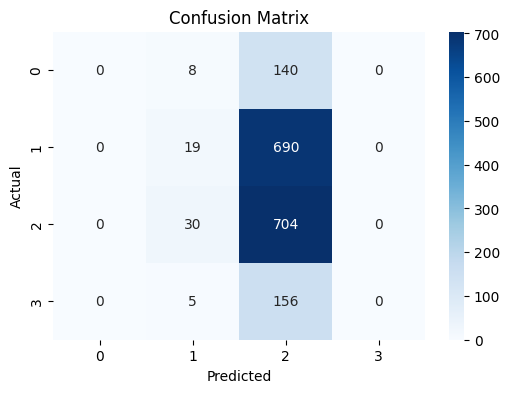

In [8]:
x_train, x_valid, y_train, y_valid = data_split(split_type, train_df, drop_colunm, target_colunm)
train_data, valid_data = _Dataset(model_name, x_train, x_valid, y_train, y_valid)

model, y_pred, accuracy, auroc = train_model(model_name, params, x_train, x_valid, y_train, y_valid, train_data, valid_data)
print(f"acc: {accuracy}, auroc: {auroc}")
show_cm(y_valid, y_pred)
submission_df = test(model_name, drop_colunm, model, test_df, submission_df)

In [9]:
submission_df.to_csv(seve_name, index=False)

### Training 결과 저장

In [10]:
date = (datetime.now()+ timedelta(hours=9)).strftime('%Y-%m-%d %H:%M:%S')
f = open('result.csv', 'a', newline='')
wr = csv.writer(f)
wr.writerow([date, accuracy, auroc, dataset_name, model_name, seve_name, split_type, params, 0])
f.close()